<!-- # 학습 개선방향
### 데이터 
- `04_014_FE.ipynb`에서 전처리를 완료한 데이터를 사용하여 LightGBM을 학습
    - date_block_num >= 12 로 데이터 고정
    - test 데이터에 존재하는 item_id로 데이터 필터링
    - item_name에 대한 파생 피처 생성
### 학습
- 학습 결과 평가
    - 모델의 예측값과 타겟값을 직접 비교
    - 예측값과 타겟값의 차이가 큰 데이터를 직접 확인
    - 검증(10월) 데이터에 대한 예측값의 평균보다 테스트(11월) 데이터에 대한 예측값의 평균이 낮아야 함. 데이터를 통해 11월의 매출이 1년 중 가장 낮은 것을 확인 -->

# Module

In [1]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor, Pool

%matplotlib inline
plt.style.use("seaborn-v0_8-white")
pd.options.display.float_format = '{:.6f}'.format

 # Data

In [2]:
data_path = "./data/"

# old_one = joblib.load(data_path + 'all_data2.joblib')
all_data = joblib.load(data_path + 'all_data_result.joblib')
test = pd.read_csv(data_path + 'test.csv')
all_data.shape, test.shape

((8812167, 38), (214200, 3))

In [3]:
print(all_data.duplicated(subset=['date_block_num', 'shop_id', 'item_id']).sum())
print(all_data['date_block_num'].min())

0
0


In [4]:
temp = all_data.isna().sum()
print(temp[temp > 0])
del temp

date_item_avg_price_lag_1    2027634
rolling_3m_price_mean        1194831
dtype: int64


In [5]:
# all_data.fillna(-999, inplace=True)

In [6]:
sorted(all_data.columns.tolist())

['category_nov_ratio',
 'city',
 'city_item_avg_date_sales_lag_1',
 'date_block_num',
 'date_item_avg_price_lag_1',
 'delta_price_lag',
 'item_age',
 'item_avg_date_sales_diff_1',
 'item_avg_date_sales_diff_2',
 'item_avg_date_sales_lag_1',
 'item_avg_date_sales_lag_2',
 'item_category_avg_date_sales_lag_1',
 'item_category_avg_date_sales_lag_2',
 'item_category_id',
 'item_cnt_month',
 'item_cnt_month_diff_1',
 'item_cnt_month_diff_2',
 'item_cnt_month_lag_1',
 'item_cnt_month_lag_2',
 'item_cnt_month_lag_3',
 'item_id',
 'item_shop_age',
 'item_shop_last_sale',
 'meta',
 'month',
 'new_item_effect',
 'platform',
 'rolling_3m_cnt_mean',
 'rolling_3m_cnt_std',
 'rolling_3m_item_cat_mean',
 'rolling_3m_item_mean',
 'rolling_3m_item_std',
 'rolling_3m_price_mean',
 'shop_id',
 'shop_item_category_avg_date_sales_lag_1',
 'transaction_cnt_lag_1',
 'transaction_cnt_lag_2',
 'type_code']

# Model

## Validation

In [7]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8812167 entries, 0 to 8812166
Data columns (total 38 columns):
 #   Column                                   Dtype  
---  ------                                   -----  
 0   shop_id                                  int8   
 1   item_id                                  int16  
 2   date_block_num                           int8   
 3   item_cnt_month                           int8   
 4   city                                     int8   
 5   item_category_id                         int8   
 6   platform                                 int8   
 7   meta                                     int8   
 8   type_code                                int8   
 9   month                                    int8   
 10  shop_item_category_avg_date_sales_lag_1  float32
 11  city_item_avg_date_sales_lag_1           float32
 12  transaction_cnt_lag_1                    int8   
 13  date_item_avg_price_lag_1                float64
 14  item_cnt_month_lag

In [8]:
for col in all_data.columns:
    if all_data[col].dtype == 'float64':
        all_data[col] = all_data[col].astype('float32')

In [9]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8812167 entries, 0 to 8812166
Data columns (total 38 columns):
 #   Column                                   Dtype  
---  ------                                   -----  
 0   shop_id                                  int8   
 1   item_id                                  int16  
 2   date_block_num                           int8   
 3   item_cnt_month                           int8   
 4   city                                     int8   
 5   item_category_id                         int8   
 6   platform                                 int8   
 7   meta                                     int8   
 8   type_code                                int8   
 9   month                                    int8   
 10  shop_item_category_avg_date_sales_lag_1  float32
 11  city_item_avg_date_sales_lag_1           float32
 12  transaction_cnt_lag_1                    int8   
 13  date_item_avg_price_lag_1                float32
 14  item_cnt_month_lag

In [ ]:
# all_data['shop_category'] = all_data['shop_id'].astype(str) + '_' + all_data['item_category_id'].astype(str)
# all_data['shop_item'] = all_data['shop_id'].astype(str) + '_' + all_data['item_id'].astype(str)
# all_data['month_cat'] = all_data['month'].astype(str) + '_' + all_data['item_category_id'].astype(str)
# all_data['month_shop'] = all_data['month'].astype(str) + '_' + all_data['shop_id'].astype(str)
# all_data['city_cat'] = all_data['city'].astype(str) + '_' + all_data['item_category_id'].astype(str)

In [ ]:
drop_cols = ['item_cnt_month', 'item_avg_date_sales_lag_1', 'item_category_avg_date_sales_lag_2', ] # 
val_month = 33

train_mask = all_data['date_block_num'] < val_month
x_train = all_data.loc[train_mask].drop(drop_cols, axis=1)

val_mask = all_data['date_block_num'] == val_month
x_val = all_data.loc[val_mask].drop(drop_cols, axis=1)

y_train = all_data.loc[train_mask, 'item_cnt_month'].clip(0, 20)
y_val = all_data.loc[val_mask, 'item_cnt_month'].clip(0, 20)

test_mask = all_data['date_block_num'] == 34
x_test = all_data.loc[test_mask].drop(drop_cols, axis=1)

print(f'학습데이터 : {x_train.shape}')

cat_features = ['shop_id', 'item_category_id', 'city', \
    'type_code', 'platform', 'month', 'meta', ]#\
        #'shop_category', 'shop_item', 'month_cat', 'month_shop', 'city_cat'] #  


# tunning
best_params = {
    'loss_function': 'RMSE',
    'eval_metric': 'RMSE',
    'random_seed': 2025,
    'grow_policy': 'Lossguide',
    'learning_rate': 0.03, 
    'random_strength' : 2,
    'bootstrap_type': 'Bernoulli',
    'subsample': 0.638, # 0.638
    'l2_leaf_reg': 1.5,
    'min_data_in_leaf' : 20,
    'max_depth' : 8,
    'task_type' : 'GPU',
    'devices' : '0',
    'od_type' : 'Iter',
    'od_wait' : 200,
    'has_time' : True,
    'nan_mode' : 'Min',
    'leaf_estimation_method': 'Gradient',
    'max_ctr_complexity' : 1, # 범주형 피처 복잡도 제한
    'simple_ctr' : ['FloatTargetMeanValue', 'Buckets', 'Borders'],
    'one_hot_max_size' : 9, # 고유값 개수가 적은 범주형 피처는 CTR이 아닌 원핫인코딩
    'model_size_reg' : 0.5, # CTR 내부 구조 복잡도 제한 L2 규제
    'border_count' : 128, # 수치형 변수의 분할 제한. gpu 기본값 128
}

train_pool = Pool(x_train, y_train, cat_features=cat_features)
val_pool = Pool(x_val, y_val, cat_features=cat_features)
test_pool = Pool(x_test, cat_features=cat_features)

cat_model = CatBoostRegressor(
    iterations=5000,
    **best_params,   
)

cat_model.fit(
    train_pool,
    eval_set=val_pool,
    verbose=100,
    use_best_model=True,
)

학습데이터 : (8376165, 40)


Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.


0:	learn: 1.2279927	test: 1.0682581	best: 1.0682581 (0)	total: 143ms	remaining: 11m 53s
100:	learn: 0.9153837	test: 0.8140300	best: 0.8140300 (100)	total: 7.2s	remaining: 5m 49s
200:	learn: 0.8923640	test: 0.8018863	best: 0.8018863 (200)	total: 14.5s	remaining: 5m 46s
300:	learn: 0.8786276	test: 0.8000897	best: 0.7997380 (289)	total: 22.1s	remaining: 5m 45s
400:	learn: 0.8684811	test: 0.7947014	best: 0.7947014 (400)	total: 29.6s	remaining: 5m 39s
500:	learn: 0.8599312	test: 0.7926390	best: 0.7922649 (492)	total: 37s	remaining: 5m 32s
600:	learn: 0.8528013	test: 0.7949902	best: 0.7922649 (492)	total: 44.3s	remaining: 5m 24s
bestTest = 0.7922648733
bestIteration = 492
Shrink model to first 493 iterations.


In [ ]:
# BASE
# 2900:	learn: 0.8393382	test: 0.7920160	best: 0.7912487 (2692) | LB : 0.89097
#### item_id 범주 제거, l2_leaf_reg 3, 
# 1900:	learn: 0.8661320	test: 0.8076461	best: 0.8060188 (1633) | LB : 0.90500
#### subsample 0.8, l2_leaf_reg 2
# 1600:	learn: 0.8734947	test: 0.8003444	best: 0.8001817 (1377) | LB : 0.91045
#### subsample 0.638, l2_leaf_reg 1.5
# 1000:	learn: 0.8478498	test: 0.8040516	best: 0.7992323 (703) | LB : 0.89211
#### subsample 0.66, lr=0.05, odd_wait=200,
# 500:	learn: 0.8558550	test: 0.8026687	best: 0.7953302 (356) | LB : 0.90204
#### subsample=0.638, lr=0.03,
# 900:	learn: 0.8522554	test: 0.8036584	best: 0.7992323 (703) | LB : 0.89211
#############
#### 변수 조합
# 600:	learn: 0.8528013	test: 0.7949902	best: 0.7922649 (492) | LB : 0.90295

In [13]:
print('Best score: ', cat_model.get_best_score()['validation']['RMSE'])
print('Best iteration: ', cat_model.get_best_iteration())

Best score:  0.7922648732783459
Best iteration:  492


In [14]:
val_preds = cat_model.predict(val_pool).clip(0, 20)
print(f'CV Prediction Mean  :{val_preds.mean()}')
print(f'Validation Mean     :{y_val.mean()}')
print(len(val_preds[val_preds < 0.3]) / len(val_preds))
print(len(y_val[y_val < 0.3]) / len(y_val))

CV Prediction Mean  :0.2683590269478254
Validation Mean     :0.2576667478201279
0.8051911164011145
0.8616108060342107


## Learning Curve

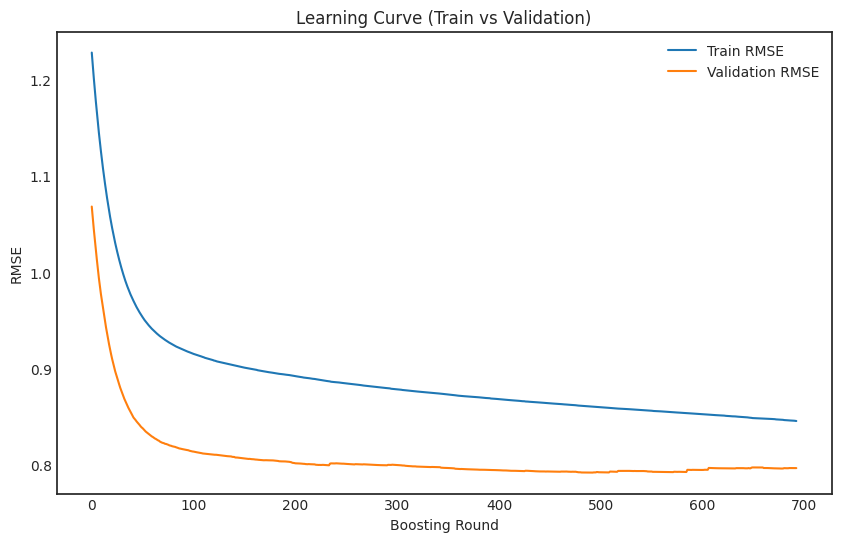

In [15]:
evals_result = cat_model.get_evals_result()

metric = 'RMSE' 
train_metric = evals_result['learn'][metric]
val_metric = evals_result['validation'][metric]

plt.figure(figsize=(10, 6))
sns.lineplot(x=range(len(train_metric)), y=train_metric, label='Train RMSE')
sns.lineplot(x=range(len(val_metric)), y=val_metric, label='Validation RMSE')
plt.title('Learning Curve (Train vs Validation)')
plt.xlabel('Boosting Round')
plt.ylabel('RMSE')
plt.legend()
plt.show()

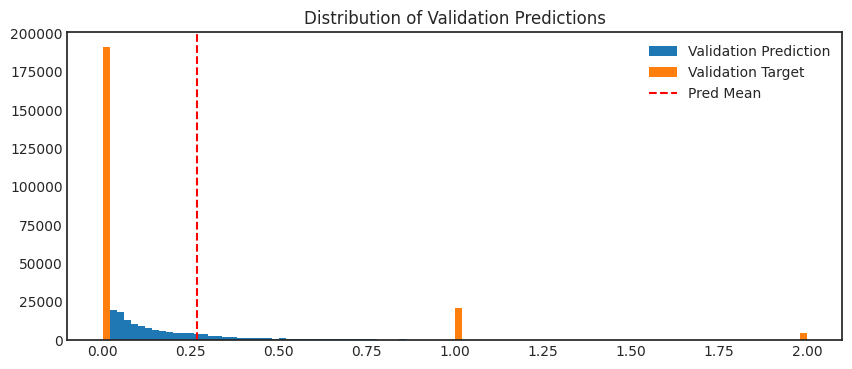

In [16]:
plt.figure(figsize=(10, 4))
plt.hist(val_preds, bins=100, range=(0, 2), label='Validation Prediction')
plt.hist(y_val, bins=100, range=(0, 2), label='Validation Target')
plt.axvline(x=val_preds.mean(), color='r', linestyle='--', label='Pred Mean')
plt.title("Distribution of Validation Predictions")
plt.legend()
plt.show()

## Residual

In [17]:
analysis_df = x_val.copy()
analysis_df['target'] = y_val
analysis_df['pred'] = val_preds
analysis_df['gap'] = analysis_df['target'] - analysis_df['pred']

cols_to_check = ['shop_id', 'item_id', 'item_category_id', 'item_cnt_month_lag_1', 'target', 'pred', 'gap', \
                 'item_age', 'item_shop_age',]

analysis_df.sort_values(by='gap', ascending=False)[cols_to_check].head(10)

,shop_id,item_id,item_category_id,item_cnt_month_lag_1,target,pred,gap,item_age,item_shop_age
8512399,40,17270,37,0,20,0.000000,20.000000,12,0
8512299,40,16629,37,0,20,0.000000,20.000000,11,0
8513395,40,21811,37,0,20,0.002636,19.997364,12,12
8510799,40,11055,37,0,20,0.022483,19.977517,12,5
8418171,12,20949,71,0,20,0.328170,19.671830,12,10
8519298,42,2431,24,0,20,0.407562,19.592438,10,10
8523630,42,20386,72,1,20,0.669798,19.330202,7,7
8521857,42,13241,47,0,20,1.428050,18.571950,0,0
8521862,42,13247,47,0,20,1.428050,18.571950,0,0
8523640,42,20405,72,2,20,1.493406,18.506594,11,11


In [18]:
analysis_df.sort_values(by='gap', ascending=True)[cols_to_check].head(10)

,shop_id,item_id,item_category_id,item_cnt_month_lag_1,target,pred,gap,item_age,item_shop_age
8412890,11,20949,71,20,3,16.483328,-13.483328,12,12
8519212,42,2047,30,20,0,11.522439,-11.522439,12,12
8476964,31,2047,30,18,0,11.467500,-11.467500,12,12
8519528,42,3341,19,20,0,10.714946,-10.714946,12,12
8415173,12,8547,42,20,2,12.448262,-10.448262,1,1
8461580,25,3849,20,0,0,10.296026,-10.296026,0,0
8477423,31,3849,20,0,0,10.268338,-10.268338,0,0
8477402,31,3759,20,0,0,10.208559,-10.208559,0,0
8461559,25,3759,20,0,0,10.124943,-10.124943,0,0
8475523,28,17755,20,0,0,9.368379,-9.368379,0,0


## feature importance

In [19]:
importance = cat_model.get_feature_importance(type='PredictionValuesChange')
feature_names = cat_model.feature_names_

feature_imp = pd.DataFrame({
'feature': feature_names,
'importance': importance
}).sort_values(by='importance', ascending=False).reset_index(drop=True)

feature_imp['normalized_importance'] = feature_imp['importance'] / feature_imp['importance'].sum()
feature_imp['cumulative_importance'] = feature_imp['normalized_importance'].cumsum()
feature_imp.tail(10)

,feature,importance,normalized_importance,cumulative_importance
30,item_category_avg_date_sales_lag_1,0.571898,0.005719,0.976771
31,item_avg_date_sales_diff_2,0.532789,0.005328,0.982099
32,shop_item_category_avg_date_sales_lag_1,0.427395,0.004274,0.986373
33,item_cnt_month_lag_3,0.352773,0.003528,0.989901
34,item_shop_age,0.311558,0.003116,0.993016
35,city_cat,0.231041,0.002310,0.995327
36,city,0.181984,0.001820,0.997147
37,item_cnt_month_lag_2,0.122432,0.001224,0.998371
38,item_cnt_month_diff_2,0.082049,0.000820,0.999191
39,item_shop_last_sale,0.080852,0.000809,1.000000


In [20]:
low_col = feature_imp.tail(10)['feature'].to_list()
low_col

['item_category_avg_date_sales_lag_1',
 'item_avg_date_sales_diff_2',
 'shop_item_category_avg_date_sales_lag_1',
 'item_cnt_month_lag_3',
 'item_shop_age',
 'city_cat',
 'city',
 'item_cnt_month_lag_2',
 'item_cnt_month_diff_2',
 'item_shop_last_sale']

/tmp/ipykernel_8313/1903301485.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_imp.head(40), palette='viridis')


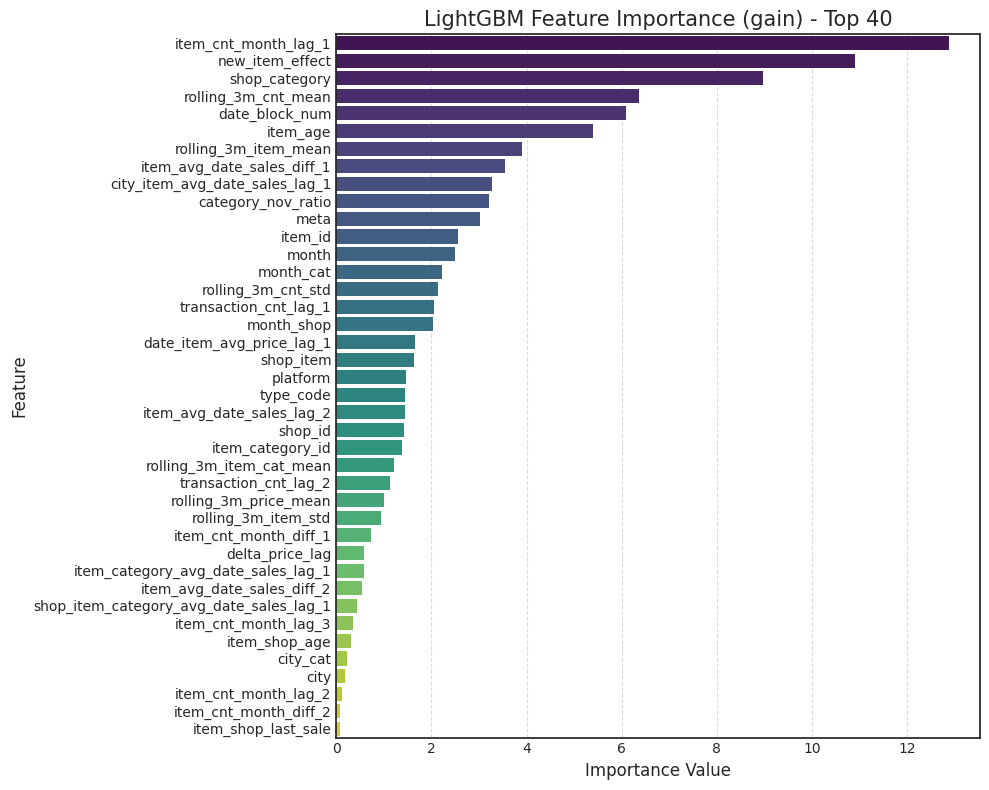

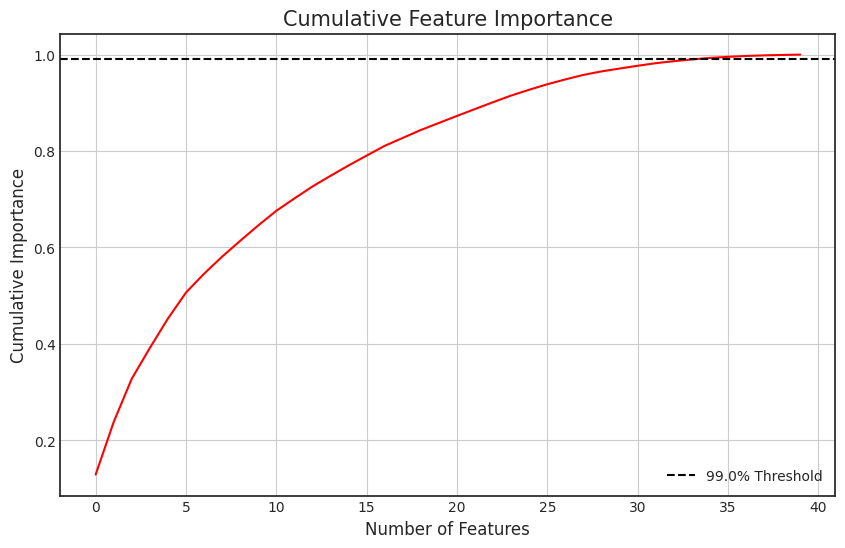

[GAIN] 분석 결과:
- 전체 피처 수: 40
- 99.0% 중요도를 설명하는 피처 수: 35
- 제거 추천 피처 수: 5
Low importance features :  ['city_cat', 'city', 'item_cnt_month_lag_2', 'item_cnt_month_diff_2', 'item_shop_last_sale']


In [21]:
def analyze_and_filter_features(feature_imp, importance_type='gain', cum_threshold=0.99):
    plt.figure(figsize=(10, 8))    
    sns.barplot(x='importance', y='feature', data=feature_imp.head(40), palette='viridis')
    plt.title(f'LightGBM Feature Importance ({importance_type}) - Top 40', fontsize=15)
    plt.xlabel('Importance Value', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(10, 6))
    plt.plot(feature_imp.index, feature_imp['cumulative_importance'], 'r-')
    plt.axhline(y=cum_threshold, color='k', linestyle='--', label=f'{cum_threshold*100}% Threshold')
    plt.title('Cumulative Feature Importance', fontsize=15)
    plt.xlabel('Number of Features', fontsize=12)
    plt.ylabel('Cumulative Importance', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.show()

    cutoff_index = feature_imp[feature_imp['cumulative_importance'] > cum_threshold].index[0]
    selected_features = feature_imp.loc[:cutoff_index, 'feature'].tolist()
    removed_features = feature_imp.loc[cutoff_index+1:, 'feature'].tolist()
    
    print(f"[{importance_type.upper()}] 분석 결과:")
    print(f"- 전체 피처 수: {len(feature_imp)}")
    print(f"- {cum_threshold*100}% 중요도를 설명하는 피처 수: {len(selected_features)}")
    print(f"- 제거 추천 피처 수: {len(removed_features)}")
    
    return feature_imp, removed_features

df_imp, del_cols = analyze_and_filter_features(feature_imp, importance_type='gain', cum_threshold=0.99)
print('Low importance features : ', del_cols)

# Prediction

In [22]:
cat_test_preds = cat_model.predict(test_pool).clip(0, 20)

In [23]:
# x_test는 all_data에서 왔으므로, 여기에 어떤 Shop ID가 들어있는지 확인하고 통일합니다.
df_pred = all_data.loc[all_data['date_block_num'] == 34, ['shop_id', 'item_id']].copy()
df_pred['item_cnt_month'] = cat_test_preds

test.loc[test['shop_id'] == 0, 'shop_id'] = 57
test.loc[test['shop_id'] == 1, 'shop_id'] = 58
test.loc[test['shop_id'] == 10, 'shop_id'] = 11
test.loc[test['shop_id'] == 39, 'shop_id'] = 40

submission = pd.merge(test, df_pred, on=['shop_id', 'item_id'], how='left')
submission[['ID', 'item_cnt_month']].to_csv('./data/submission_catb.csv', index=False)

In [24]:
submission.head(10)

,ID,shop_id,item_id,item_cnt_month
0,0,5,5037,0.613049
1,1,5,5320,0.284871
2,2,5,5233,0.821253
3,3,5,5232,0.335877
4,4,5,5268,3.461962
5,5,5,5039,0.623342
6,6,5,5041,0.607371
7,7,5,5046,0.121108
8,8,5,5319,1.013925
9,9,5,5003,0.401100


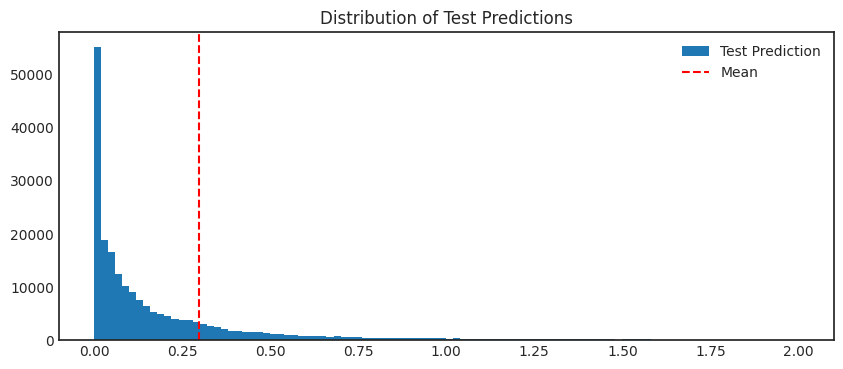

In [25]:
plt.figure(figsize=(10, 4))
plt.hist(cat_test_preds, bins=100, range=(0, 2), label='Test Prediction')
plt.axvline(x=cat_test_preds.mean(), color='r', linestyle='--', label='Mean')
plt.title("Distribution of Test Predictions")
plt.legend()
plt.show()

# submission

In [26]:
!chmod 600 /teamspace/studios/this_studio/.kaggle/kaggle.json
!kaggle competitions submit -c competitive-data-science-predict-future-sales -f "./data/submission_catb.csv" -m "submission_catb"

100%|██████████████████████████████████████| 4.98M/4.98M [00:00<00:00, 16.0MB/s]
Successfully submitted to Predict Future Sales